# $\mathrm{DL \: Inversion \: of \: RESOLVE}$
## * Before you run all cells, please fill out INPUT CELL.

## Import Python Libraries

In [1]:
# Built-in : 
import sys, os
import json
import warnings
# Dependent : 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import scipy.constants as const
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ipywidgets import interact, widgets, interact_manual
from ipywidgets import Layout, HBox, VBox
from IPython.display import display, Javascript
from tkinter import*
from tkinter import filedialog

from tensorflow.keras.models import load_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# Local script : 
sys.path.append('../../')
from script import ModelingToolKit as mtk
from script import GenerateDataset as gd
from script import networks
from script import emplot
from script import emforward as emf
from script import emdlGL as gl
%matplotlib inline

## INPUT CELL

In [2]:
# name of this inversion (filename header)
name = 'sample'

In [3]:
### 1D HORIZONTAL MULTI-LAYERD STRUCTURE MODEL #####################
surface_layer_thickness = 0.5

final_boundary_depth = 150

number_of_layers = 30

split_scale = 'log'
# Thickness / manual
manual_thickness = []

# Resistivity range (Ohm-m)
resistivity_range = [1, 10000]

# Resistivity generation mode
generate_mode = 'TypeA'


### RESOLVE SYSTEM #################################################
# Bird height range (m)
bird_height_range = [20, 100]

# Operating Frequencies (Hz) / nominal frequencies : freqs = [140000, 40000, 8200, 3300, 1800, 400]
# VCA(VCX) Coil data around 3300 Hz is optional, but must be included at 4th index of the list.
freqs = [130100, 35920, 7970, 3528, 1822, 382]

# Operating Coil Separation (m) / nominal separation : spans = [7.86, 7.86, 7.86, 8.99, 7.86, 7.86]
# VCA(VCX) Coil data around 3300 Hz is optional, but must be included at 4th index of the list.
# Order must be the same as frequencies list.
spans = [7.86, 7.86, 7.86, 8.99, 7.86, 7.86]

# Gauss Noise Level
## average (ppm)
noise_ave = [0, 0, 0, 0, 0, 0]
## standard deviation (ppm)
noise_std = [50, 40, 20, 10, 10, 10]


### DEEP LEARNING ##################################################
# Dataset size
dataset_size = 5000
# Batch size
batch_size = 600
# Epochs
epochs = 50

## Model Definition

In [4]:
warnings.simplefilter('ignore')
thickness = mtk.tmake(surface_layer_thickness, final_boundary_depth, number_of_layers, scale=split_scale)
if manual_thickness:
    thickness = manual_thickness
depth = mtk.dmake(thickness)
mtk.show_structure(thickness, depth)


Layer Boundary Depth (m)
  0.000 |   0.500 |   0.613 |   0.751 |   0.921 |   1.129 |   1.385 |   1.697 |   2.081 |   2.551 | 
  3.127 |   3.834 |   4.700 |   5.762 |   7.064 |   8.660 |  10.617 |  13.016 |  15.956 |  19.562 | 
 23.981 |  29.400 |  36.042 |  44.185 |  54.169 |  66.407 |  81.411 |  99.805 | 122.355 | 150.000 | 
Layer Thickness (m)
  0.500 |   0.113 |   0.138 |   0.170 |   0.208 |   0.255 |   0.313 |   0.384 |   0.470 |   0.576 | 
  0.707 |   0.866 |   1.062 |   1.302 |   1.596 |   1.957 |   2.399 |   2.941 |   3.605 |   4.420 | 
  5.418 |   6.643 |   8.143 |   9.983 |  12.239 |  15.004 |  18.394 |  22.550 |  27.645 | infinity|


## Generate Datasets

In [5]:
config = {
    'size' : dataset_size,
    'thicks' : thickness,
    'bgrlim' : resistivity_range,
    'bhlim' : bird_height_range,
    'freqs' : freqs,
    'spans' : spans,
    'noise_ave' : noise_ave,
    'noise_std' : noise_std,
    'generate_mode' : generate_mode
}

dataset_dir = 'result/'
dsetfile_path = dataset_dir + name + '_dataset.csv'

model_dir = 'network/'
histfile_path = model_dir + name + '_history.csv'
nnetfile_path = model_dir + name + '_network.h5'

if os.path.exists(dsetfile_path):
    df = pd.read_csv(dsetfile_path, header=None)
    network = load_model(nnetfile_path)
    hist_df = pd.read_csv(histfile_path)
    tofit = False
    print('The Specified Dataset & Neural Network Model Already Exists.')
else:
    resolve = gd.Resolve1D(**config)
    data = resolve.proceed()
    df = pd.DataFrame(data)
    df.to_csv(dsetfile_path, header=None, index=False)
    tofit = True
    print("-> /" + dsetfile_path)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
The Specified Dataset & Neural Network Model Already Exists.


## Deep Learning

In [6]:
# 説明変数の次元
bird_height_in_x = True
nx = 2 * len(freqs) + int(bird_height_in_x)
# 層数
nlayer = len(depth)

#分割
x = df.iloc[:, :nx].values
y = df.iloc[:, nx:].values
y = np.log10(y)
x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=0.02, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=0)
x_test_org = x_test.copy()
y_test_org = y_test.copy()

#正規化
sc = preprocessing.StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)
x_val = sc.transform(x_val)

# 新しいデータセットが用意された場合、学習を実行する
if tofit:
    input_dim = x.shape[1]
    output_dim = y.shape[1]
    network = networks.get_dnn(input_dim, output_dim)
    history = network.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(x_val, y_val))
    network.save(nnetfile_path)
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(histfile_path)


## Validation Test

<Figure size 432x288 with 0 Axes>

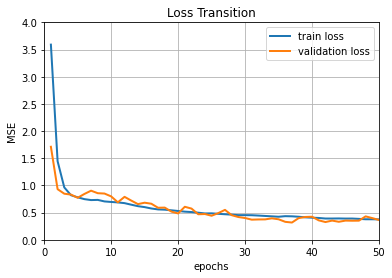

In [7]:
gl.loss_plot(hist_df, epochs)

# Inversion

In [10]:
def get_file_path(mode):
    %gui tk
    # Create Tk root
    root = Tk()
    # Hide the main window
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    typ = [('CSV','*.csv')] 
    infiles = filedialog.askopenfilename(filetypes=typ)
    
    if infiles == "":
        sys.exit(1)
    elif mode == "Read Existing Result":
        f = open('reflog.txt', 'w')
        f.write(infiles)
        f.close()
        display(Javascript('IPython.notebook.execute_cells_below()'))
    else:
        f = open('ref.txt', 'w')
        f.write(infiles)
        f.close()
        display(Javascript('IPython.notebook.execute_cells_below()'))

mode = ['Read New File', 'Read Existing Result']

myim = interact_manual.options(manual_name='Open File')
myim(get_file_path, mode=mode);

interactive(children=(Dropdown(description='mode', options=('Read New File', 'Read Existing Result'), value='R…

In [11]:
if os.path.exists('ref.txt'):
    f = open('ref.txt', 'r')
    fielddata_filepath = f.read()
    f.close()
    os.remove('ref.txt')
    data = pd.read_csv(fielddata_filepath)
    data.head()
    ex_result = False
elif os.path.exists('reflog.txt'):
    print('Hi')
    f = open('reflog.txt', 'r')
    save_path = f.read()
    f.close()
    os.remove('reflog.txt')
    ex_result = True
else:
    raise Exception('Could not open file. Open file and retry.')

if not ex_result:
    headers = list(data.columns)

    #def select_header(cols):

    style = {'description_width': 'initial'}

    line = widgets.Dropdown(options=headers, value=None, description='Line No :', disabled=False)
    fid = widgets.Dropdown(options=headers, value=None, description='Fiducial No :', disabled=False)
    be = widgets.Dropdown(options=headers, value=None, description='Bird Easting :', disabled=False)
    bn = widgets.Dropdown(options=headers, value=None, description='Bird Northing :', disabled=False, style=style)
    el = widgets.Dropdown(options=headers, value=None, description='Elevation :', disabled=False)

    str_freqs = [str(f) for f in freqs]
    EMI = []
    EMQ = []
    for sf in str_freqs:
        descriptionI = sf + ' Hz I:'
        descriptionQ = 'Q:'
        emi = widgets.Dropdown(options=headers, value=None, description=descriptionI, disabled=False)
        emq = widgets.Dropdown(options=headers, value=None, description=descriptionQ, disabled=False)
        EMI.append(emi)
        EMQ.append(emq)
    bh = widgets.Dropdown(options=headers, value=None, description='Bird AGL Altitude', disabled=False, style=style)

    label = widgets.Text(value='', description='Save as :', disabled=False)
    no = widgets.Text(value='', description='Null object (Optional):', disabled=False, style=style)

    check = widgets.Checkbox(
        value=False,
        description='Selection Completed',
        disabled=False,
        indent=False
    )

    VB = VBox([
        HBox([line, fid, el]), 
        HBox([be, bn, bh]), 
        HBox([EMI[0], EMQ[0]]),
        HBox([EMI[1], EMQ[1]]),
        HBox([EMI[2], EMQ[2]]),
        HBox([EMI[3], EMQ[3]]), 
        HBox([EMI[4], EMQ[4]]),
        HBox([EMI[5], EMQ[5]]),
        HBox([no]),
        HBox([check]),
        HBox([label, widgets.Label(value='.csv')]),
    ])
    display(VB)

### Header Selection

In [14]:
def run_below():
    display(Javascript('IPython.notebook.execute_cells_below()'))

if not ex_result:
    myim = interact_manual.options(manual_name='Run Below')
    myim(run_below);
else:
    pass

interactive(children=(Button(description='Run Below', style=ButtonStyle()), Output()), _dom_classes=('widget-i…

In [15]:
if ex_result:
    print('reading ' + save_path)
    config_name = save_path.split(sep='.')[0]
    config_name = config_name.split(sep='/')[-1]
    config_path = f'result/config_{config_name}.json'
    json_open = open(config_path, 'r')
    jdict = json.load(json_open)
    IDHeader = jdict['header']['IDHeader']
    LocHeader = jdict['header']['LocHeader']
    BHHeader = jdict['header']['BHHeader']
    RESHeader = jdict['header']['RESHeader']

elif check.value:
    IDHeader = [
        line.value, fid.value
    ]

    # Bird UTM coordinate, Elevation (m)
    LocHeader = [
        be.value, bn.value, el.value
    ]

    # Magnetic Field data (ppm)
    EMIHeader = [EMI[i].value for i in range(6)]
    EMQHeader = [EMQ[i].value for i in range(6)]

    EMHeader = [
        *EMIHeader, *EMQHeader
    ]

    # Bird Height (m)
    BHHeader = bh.value

    # Missing Data Object
    nan_char = [no.value]

    save_path = "result/" + label.value + ".csv"

    datafile_format = fielddata_filepath.split(sep='.')[-1]

    pickup_columns = IDHeader + LocHeader + EMHeader + [BHHeader]
    numlayer = len(depth)
    RESHeader = ['R{}'.format(i+1) for i in range(numlayer)]
    XVHeader = EMHeader + [BHHeader]
    YVHeader = RESHeader
    
    if os.path.exists(save_path):
        print('the result has already saved.')
        pass
    else:
        if datafile_format == 'csv':
            data = pd.read_csv(fielddata_filepath)
            dfd = data.loc[:, pickup_columns].values
            df = pd.DataFrame(dfd, columns=pickup_columns)
            # 欠損値を含む行
            for c in nan_char:
                df = df.replace(c, np.nan)

            for xh in XVHeader:
                df = df[df[xh] != np.nan]

            x = df[XVHeader].values
            ide = df[IDHeader].values
            loc = df[LocHeader].values
            h = np.array([df[BHHeader].values]).T

            stdx = sc.transform(x)
            y = network.predict(stdx)
            y = 10 ** y

            header = [*IDHeader, *LocHeader, 'ALTBIRDO', *XVHeader, *YVHeader]
            rdata = np.hstack([ide, loc, h, x, y])
            rdf = pd.DataFrame(rdata)
            rdf.to_csv(save_path, header=header, index=False)
            print('the result is saved at ' + save_path)
        else:
            print('datafile format must be csv')
            
else:
    raise Exception('Header Selection is not done yet.')

the result is saved at result/tohoku.csv


In [16]:
if not ex_result:
    # 設定の保存
    settings = {
        'network' : {
            'name' : name,
            'dataset_size' : dataset_size,
            'epochs' : epochs,
            'batch_size' : batch_size,

        },
        'subsurface' : {
            'thickness' : list(thickness),
            'depth' : list(depth)

        },
        'resolvedataset' : {
            'resistivity_range' : resistivity_range,
            'bird_height_range' : bird_height_range,
            'frequency' : freqs,
            'separetion' : spans,
            'noise_ave' : noise_ave,
            'noise_std' : noise_std,
            'generate_mode' : generate_mode
        },
        'header' : {
            'IDHeader' : [line.value, fid.value],
            'LocHeader' : [be.value, bn.value, el.value],
            'EMIHeader' : [EMI[i].value for i in range(6)],
            'EMQHeader' : [EMQ[i].value for i in range(6)],
            'BHHeader' : bh.value,
            'RESHeader' : ['R{}'.format(i+1) for i in range(nlayer)]
        }
    }
    config_name = save_path.split(sep='.')[0]
    config_name = config_name.split(sep='/')[-1]
    config_path = f'result/config_{config_name}.json'
    if not os.path.exists(config_path):
        with open(config_path, 'w') as fp:
            json.dump(settings, fp, indent=4)
    else:
        print('Already saved')

## Resistivity / Conductivity Depth Image

In [23]:
import scipy.constants as const
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, widgets, interact_manual
from IPython.display import display


df = pd.read_csv(save_path)
lines = df[IDHeader[0]].values
linetype = lines.dtype
if lines.dtype in [np.float64]:
    lines = lines.astype(np.int64)
lines = lines.astype(np.object)
line_no_list = []
logg = 0
for nomb in lines:
    if nomb == logg:
        logg = nomb
    else:
        line_no_list.append(nomb)
        logg = nomb

Value_min = [0.1, 1, 10, 100]
Value_max = [100, 1000, 10000, 100000]
Property = ['resistivity (Ohm-m)', 'conductivity (mS/m)']
    
def DIplot(Line_No, Property, Value_min, Value_max):
    inline = df[df[IDHeader[0]].astype(np.object)==Line_No]

    easting = inline[LocHeader[0]].values
    northing = inline[LocHeader[1]].values
    elevation = inline[LocHeader[2]].values
    linesize = len(easting)
    # from east
    if easting[0] > easting[-1]:
        start = linesize-1
    # from west
    else:
        start = 0

    distance = []
    start_east = easting[start]
    start_north = northing[start]
    for i in np.arange(0, linesize):
        dist = np.sqrt((northing[i]-start_north)**2 + (easting[i]-start_east)**2)
        distance.append(dist)
    distance = np.array(distance)

    bheight = inline[BHHeader].values
    res = inline[RESHeader].values

    if Property == 'resistivity (Ohm-m)':
        cval = res
        cmap_name = 'jet_r'
        cmap = plt.cm.jet_r
    elif Property == 'conductivity (mS/m)':
        cval = 1/res*1000
        cmap_name = 'jet'
        cmap = plt.cm.jet

    cvalmax = Value_max
    cvalmin = Value_min

    cstd = (cval-cvalmin)/(cvalmax-cvalmin)
    cmaps = plt.cm.jet_r(cstd)

    depthadd = np.append(depth, 2*depth.max())
    fmin = min(freqs)

    plt.rcParams["font.size"] = 30
    plt.tight_layout()
    #plt.style.use('default')
    fig = plt.figure(figsize=(30, 8), dpi=100)
    ax = fig.add_subplot(111)
    norm = mpl.colors.LogNorm(vmin=cvalmin, vmax=cvalmax)
    for i in range(len(distance)-1):
        progress = int(i/(linesize-2)*100)
        print("\r"+"Progress ... "+str(progress)+" %",end="")
        # apparent skin dapth
        reg = bheight[i]/np.sqrt(2e14/const.mu_0/np.pi/fmin)
        j = 0
        while (reg <= 1) and (j<29):
            reg += (depth[j+1] - depth[j]) / np.sqrt(res[i][j]/const.mu_0/np.pi/fmin)
            j += 1
        over = reg - 1
        overL = np.sqrt(res[i][j-1]/const.mu_0/np.pi/fmin) * over
        cval[i][j:] = np.nan
        depthadd = np.append(depth, 2*depth.max())
        depthadd[j] -= overL

        mesh_x, mesh_y = np.meshgrid(distance[i:i+2], -depthadd+elevation[i])
        cross_section = ax.pcolormesh(mesh_x, mesh_y, cval[i].reshape(len(cval[i]), 1), norm=norm, cmap=cmap_name, shading='flat', zorder=1)

    norm = mpl.colors.LogNorm(vmin=cvalmin, vmax=cvalmax)
    m = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    if type(Line_No) in [float, np.float64]:
        Line_No = int(Line_No)

    if Property == 'resistivity (Ohm-m)':
        cbar = fig.colorbar(m, cax=cax, label='Resistivity ($\Omega\cdot$m)', extend='both')
        ax.set_title('Resistivity Depth Image below Line ' + str(Line_No))
    elif Property == 'conductivity (mS/m)':
        cbar = fig.colorbar(m, cax=cax, label='Conductivity (mS/m)', extend='both')
        ax.set_title('Conductivity Depth Image below Line ' + str(Line_No))

    ax.set(xlim=(distance.min(), distance.max()), ylim=(-100, elevation.max()+10))
    ax.set_xlabel('Distance [m]')
    ax.set_ylabel('Elevation [m]')
    ax.grid(zorder=2)
    plt.show()

myim = interact_manual.options(manual_name='Show Image')
myim(DIplot, Line_No=line_no_list, Property=Property, Value_min=Value_min, Value_max=Value_max);

interactive(children=(Dropdown(description='Line_No', options=('L20130', 'L20140', 'L20150', 'L30160'), value=…